# Import Libraries

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split

import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier
from scipy.stats import mode

import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import log_loss
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics

import gc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings("ignore")

# Import Dataset

In [100]:
df = pd.read_csv('/kaggle/input/dstcdata/Bảng ĐH_Vòng 2_DSTC 2024_Dataset/01_dataset.csv')


In [101]:
df.head()

,customer_id,label,SHORT_TERM_COUNT,MID_TERM_COUNT,LONG_TERM_COUNT,SHORT_TERM_COUNT_BANK,MID_TERM_COUNT_BANK,LONG_TERM_COUNT_BANK,SHORT_TERM_COUNT_NON_BANK,MID_TERM_COUNT_NON_BANK,...,ENQUIRIES_FROM_BANK_6M_9M,ENQUIRIES_FROM_BANK_9M_12M,ENQUIRIES_FROM_BANK_6M_12M,ENQUIRIES_FROM_BANK_3M_12M,ENQUIRIES_FROM_NON_BANK_3M_6M,ENQUIRIES_FROM_NON_BANK_6M_9M,ENQUIRIES_FROM_NON_BANK_9M_12M,ENQUIRIES_FROM_NON_BANK_6M_12M,ENQUIRIES_FROM_NON_BANK_3M_12M,OUTSTANDING_BAL_ALL_CURRENT
0,1639,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,2.000000,2.000000,2.000000,7.000000,3.666667,7.0,3.666667,3.666667,1000000.0
1,23717,0,10.0,1.0,NaN,7.0,1.0,1.0,4.0,NaN,...,2.000000,7.000000,2.000000,2.000000,7.000000,7.000000,7.0,7.000000,7.000000,NaN
2,19474,0,7.0,7.0,NaN,7.0,NaN,1.0,1.0,4.0,...,7.000000,5.571429,5.571429,5.571429,7.000000,7.000000,7.0,7.000000,7.000000,1000620.0
3,15505,0,7.0,1.0,1.0,NaN,1.0,NaN,7.0,1.0,...,6.090909,7.000000,NaN,NaN,4.500000,5.333333,7.0,5.333333,3.666667,1000170.0
4,1538,1,NaN,NaN,1.0,1.0,1.0,1.0,1.0,4.0,...,2.000000,2.000000,2.000000,2.000000,3.666667,7.000000,7.0,7.000000,3.666667,1000270.0


# Initial Processing

### Missing Values

In [102]:
df.isnull().sum(axis = 0)

customer_id                          0
label                                0
SHORT_TERM_COUNT                  2000
MID_TERM_COUNT                    2000
LONG_TERM_COUNT                   2000
                                  ... 
ENQUIRIES_FROM_NON_BANK_6M_9M     2000
ENQUIRIES_FROM_NON_BANK_9M_12M    2000
ENQUIRIES_FROM_NON_BANK_6M_12M    2000
ENQUIRIES_FROM_NON_BANK_3M_12M    2000
OUTSTANDING_BAL_ALL_CURRENT       2000
Length: 124, dtype: int64

### Label Distribution

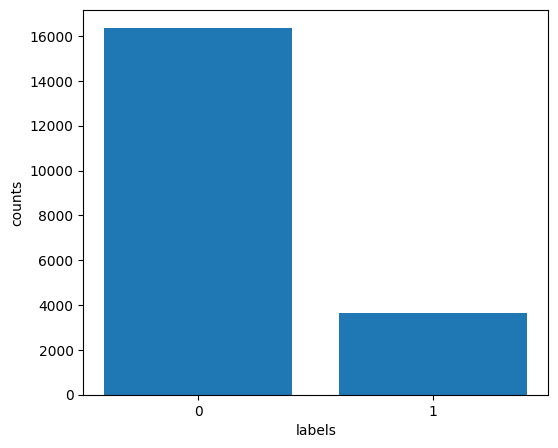

In [103]:
fig = plt.figure(figsize=(6,5))
plt.bar(df.label.value_counts().index, df.label.value_counts().values)
plt.xlabel('labels')
plt.ylabel('counts')
plt.xticks([0,1])
plt.show()

## Fill missing values with mean

In [104]:
numerical_cols = df.select_dtypes(include='number').columns
categorical_cols = df.select_dtypes(include='object').columns


for col in df.select_dtypes('object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# fill missing values with mean for numerical columns
# for col in df.select_dtypes('number').columns:
#     df[col].fillna(df[col].mean(), inplace=True)

# for col in df.select_dtypes('number').columns:
    # df[col].fillna(0, inplace=True)

for col in df.select_dtypes('number').columns:
    df[col].fillna(df[col].mean(), inplace=True)


In [105]:
df.shape

(20000, 124)

# ROC curve

In [106]:
results = []
from sklearn.metrics import roc_curve, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

def evaluate(y_test,y_pred,y_pred_proba, model):


    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    # Plot the ROC curve
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve')
    plt.fill_between(fpr, 0, tpr, color='skyblue', alpha=0.2)
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Chance')

    # Add labels and title
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve for {}'.format(model))

    # Generate classification report
    report = classification_report(y_test, y_pred)
    classification_report_str = classification_report(y_test, y_pred, output_dict=True)
    f1_score = classification_report_str['weighted avg']['f1-score']
    auc_score = roc_auc_score(y_test, y_pred_proba)

    # Print accuracy and classification report
    print("\nClassification Report:\n", report)

    # Add result
    results.append({"Model": model,"ROC AUC Score": auc_score, "F1-Score": f1_score})
    # Show the plot
    plt.show()

# Baseline Models Performances

## Baseline Model - Logistic Regression

In [107]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming your data is stored in X and y
X_train, X_val_test, y_train, y_val_test = train_test_split(df.drop("label", axis=1), df["label"], test_size=0.4, random_state=42)
# Split the validation and test sets into equal proportions
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)
X_train.drop('customer_id', axis=1, inplace=True)
X_val.drop('customer_id', axis=1, inplace=True)
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 12000
Validation set size: 4000
Test set size: 4000


Accuracy: 82.25%
AUC Score: 0.6502594289139089

Classification Report:
               precision    recall  f1-score   support

           0       0.82      1.00      0.90      3290
           1       0.00      0.00      0.00       710

    accuracy                           0.82      4000
   macro avg       0.41      0.50      0.45      4000
weighted avg       0.68      0.82      0.74      4000



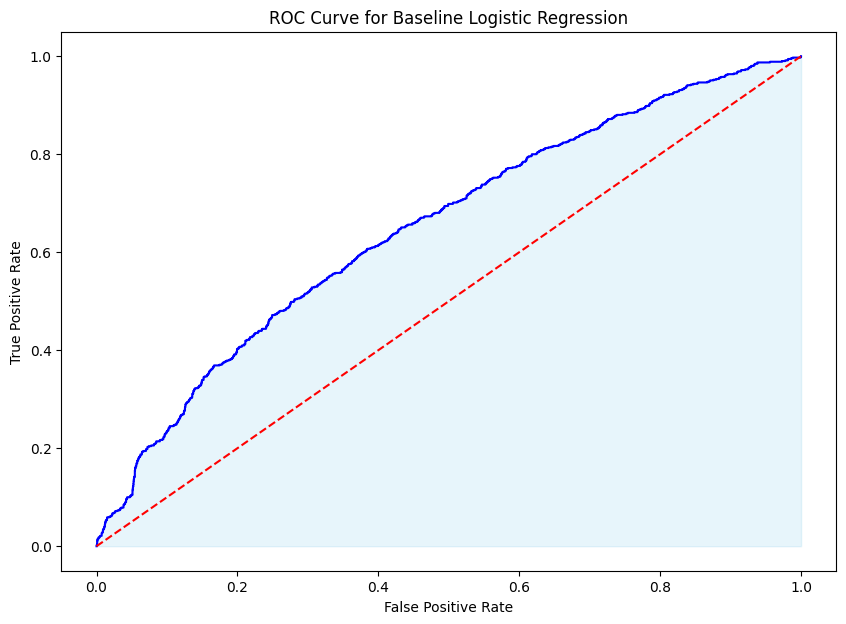

In [108]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model with 'sag' solver
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Accuracy: {accuracy * 100.0}%")
print(f"AUC Score: {auc_score}")
evaluate(y_val,y_pred,y_pred_proba, "Baseline Logistic Regression")

## Baseline Model - LightGBM

[LightGBM] [Info] Number of positive: 1773, number of negative: 7827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9824
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184688 -> initscore=-1.484906
[LightGBM] [Info] Start training from score -1.484906
[LightGBM] [Info] Number of positive: 1773, number of negative: 7827
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9827
[LightGBM] [Info] Number of data points in the train set: 9600, number of used features: 122
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.184688 -> initscore=-1.484906
[LightGBM] [Info] Start training from score -1.484906
[LightGBM] [Info

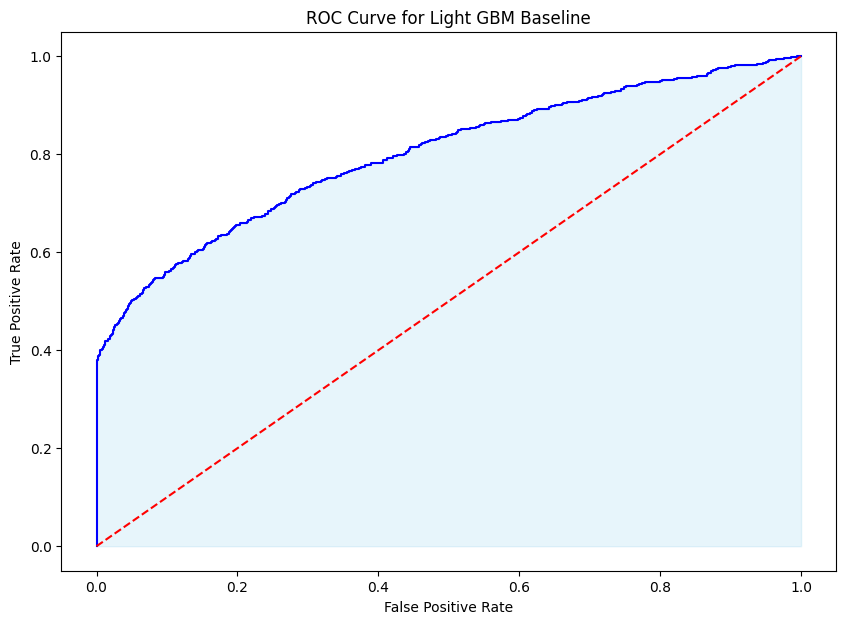

In [109]:
lgb_model = lgb.LGBMClassifier()

# Perform cross-validation
cv_scores = cross_val_score(lgb_model, X_train, y_train, cv=5, scoring='roc_auc')

# Train the model on the entire training set
lgb_model.fit(X_train, y_train)

# Predictions on the test set
lgb_y_pred = lgb_model.predict(X_val)
y_pred_proba = lgb_model.predict_proba(X_val)[:, 1]
# Calculate accuracy and AUC Score on the test set
lgb_accuracy = accuracy_score(y_val, lgb_y_pred)
lgb_auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")
print(f"Test Set Accuracy: {lgb_accuracy * 100.0}%")
print(f"Test Set AUC Score: {lgb_auc_score}")


accuracy = accuracy_score(y_val, y_pred)
auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Accuracy: {accuracy * 100.0}%")
print(f"AUC Score: {auc_score}")
evaluate(y_val,lgb_y_pred,y_pred_proba, "Light GBM Baseline")

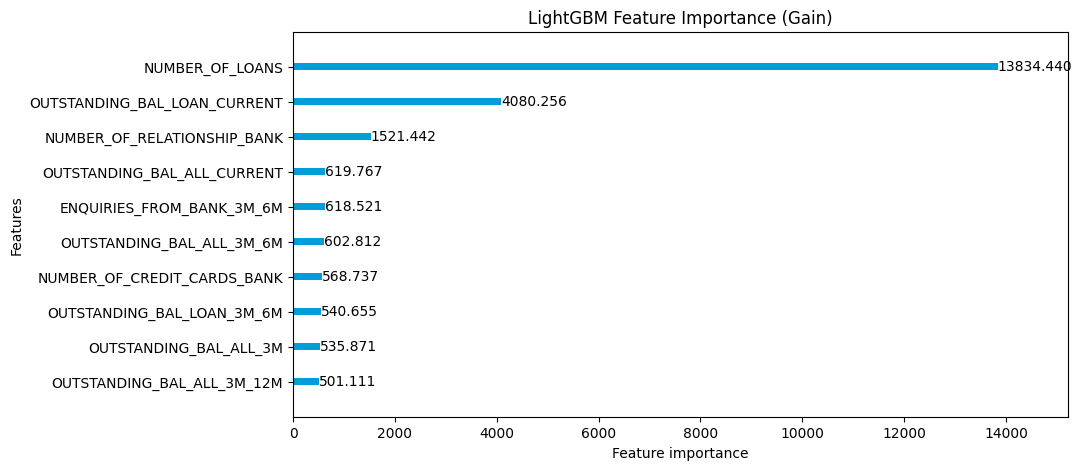

In [110]:
lgb.plot_importance(lgb_model, importance_type="gain", max_num_features=10, figsize=(10,5), title="LightGBM Feature Importance (Gain)", grid=False, color = "#009dd9")
plt.show()


# Feature Engineering

### Drop Features that has too many duplicate values

In [111]:
df.drop(["CREDIT_CARD_MONTH_SINCE_10DPD","CREDIT_CARD_MONTH_SINCE_30DPD","CREDIT_CARD_MONTH_SINCE_60DPD","CREDIT_CARD_MONTH_SINCE_90DPD"], inplace = True, axis = 1)

### Feature 1: Binary Features (Short Term, Mid Term, Long Term)

In [112]:
df_t = df[['SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT', 'label']].copy(deep=True)
df_t['MANY_SHORT'] = np.where(df_t['SHORT_TERM_COUNT'] >= 4, 1, 0)
df_t['MANY_MID'] = np.where(df_t['MID_TERM_COUNT'] >= 4, 1, 0)
df_t['MANY_LONG'] = np.where(df_t['LONG_TERM_COUNT'] >= 4, 1, 0)
df_t['Theory 1'] = (df_t['MANY_SHORT'] * 10 + df_t['MANY_MID'] * 5 + df_t['MANY_LONG']) / 15
df['Diff_in_term_count'] = df_t['Theory 1']

### Feature 2: Binary Features (Number of Loans, Number of Loans Bank, Number of Loans Non Bank) 

In [113]:
df_t = df[['NUMBER_OF_LOANS', 'NUMBER_OF_LOANS_BANK', 'NUMBER_OF_LOANS_NON_BANK', 'label']].copy(deep=True)
df_t['MANY_LOANS'] = np.where(df_t['NUMBER_OF_LOANS'] >= 4, 1, 0)
df_t['MANY_LOANS_BANK'] = np.where(df_t['NUMBER_OF_LOANS_BANK'] >= 4, 1, 0)
df_t['MANY_LOANS_NON_BANK'] = np.where(df_t['NUMBER_OF_LOANS_NON_BANK'] >= 4, 1, 0)
df_t['Theory 1'] = df_t.iloc[:, -3:].sum(axis=1)
df['Diff_in_num_loan'] = df_t['Theory 1']

### Feature 3: Differece in 3 features realted to Number of Relationships

In [114]:
df_t = df[['NUMBER_OF_RELATIONSHIP', 'NUMBER_OF_RELATIONSHIP_BANK', 'NUMBER_OF_RELATIONSHIP_NON_BANK', 'label']].copy(deep=True)
# df_t.median()
df_t['MANY_RELATIONSHIP'] = np.where(df_t['NUMBER_OF_RELATIONSHIP'] >= 4, 1, 0)
df_t['MANY_RELATIONSHIP_BANK'] = np.where(df_t['NUMBER_OF_RELATIONSHIP_BANK'] >= 4, 1, 0)
df_t['MANY_RELATIONSHIP_NON_BANK'] = np.where(df_t['NUMBER_OF_RELATIONSHIP_NON_BANK'] >= 4, 1, 0)

df_t['Theory 1'] = (df_t['MANY_RELATIONSHIP'] * 5 + df_t['MANY_RELATIONSHIP_BANK'] + df_t['MANY_RELATIONSHIP_NON_BANK']) / 7
df['Diff_in_num_relationship'] = df_t['Theory 1']

### Feature 4

In [115]:
cols = ['NUM_NEW_LOAN_TAKEN_3M', 'NUM_NEW_LOAN_TAKEN_6M',
       'NUM_NEW_LOAN_TAKEN_9M', 'NUM_NEW_LOAN_TAKEN_12M',
       'NUM_NEW_LOAN_TAKEN_BANK_3M', 'NUM_NEW_LOAN_TAKEN_BANK_6M',
       'NUM_NEW_LOAN_TAKEN_BANK_9M', 'NUM_NEW_LOAN_TAKEN_BANK_12M',
       'NUM_NEW_LOAN_TAKEN_NON_BANK_3M', 'NUM_NEW_LOAN_TAKEN_NON_BANK_6M',
       'NUM_NEW_LOAN_TAKEN_NON_BANK_9M', 'NUM_NEW_LOAN_TAKEN_NON_BANK_12M', 'label']
# cols = ['NUM_NEW_LOAN_TAKEN_3M', 'NUM_NEW_LOAN_TAKEN_6M',
#        'NUM_NEW_LOAN_TAKEN_9M', 'NUM_NEW_LOAN_TAKEN_12M', 'label']
df_t = df[cols].copy(deep=True)
df_t['MANY_NEW_LOAN_3M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_3M'] >= 1, 1, 0)
df_t['MANY_NEW_LOAN_6M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_6M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_9M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_9M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_12M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_12M'] >= 4, 1, 0)

df_t['MANY_NEW_LOAN_BANK_3M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_BANK_3M'] >= 1, 1, 0)
df_t['MANY_NEW_LOAN_BANK_6M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_BANK_6M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_BANK_9M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_BANK_9M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_BANK_12M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_BANK_12M'] >= 4, 1, 0)

df_t['MANY_NEW_LOAN_NON_BANK_3M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_NON_BANK_3M'] >= 1, 1, 0)
df_t['MANY_NEW_LOAN_NON_BANK_6M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_NON_BANK_6M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_NON_BANK_9M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_NON_BANK_9M'] >= 4, 1, 0)
df_t['MANY_NEW_LOAN_NON_BANK_12M'] = np.where(df_t['NUM_NEW_LOAN_TAKEN_NON_BANK_12M'] >= 4, 1, 0)

df_t['Theory 1'] = df_t.iloc[:, -12:].sum(axis=1)
df['Diff_in_num_new_loan'] = df_t['Theory 1']

## Feature 5: Ratio with number of loans

In [116]:
cols = ['SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT', "SHORT_TERM_COUNT_BANK","MID_TERM_COUNT_BANK","LONG_TERM_COUNT_BANK","SHORT_TERM_COUNT_NON_BANK",
        "MID_TERM_COUNT_NON_BANK","LONG_TERM_COUNT_NON_BANK","NUMBER_OF_LOANS_BANK","NUMBER_OF_LOANS_NON_BANK", "NUMBER_OF_RELATIONSHIP","NUMBER_OF_RELATIONSHIP_BANK","NUMBER_OF_RELATIONSHIP_NON_BANK",
        'NUMBER_OF_LOANS', 'label']
df_t = df[cols].copy(deep=True)
# df_t['NUMBER_OF_LOANS'].fillna(df_t['NUMBER_OF_LOANS'].mean(), inplace=True)
df[['RATIO_SHORT', 'RATIO_MID', 'RATIO_LONG']] = \
df_t[['SHORT_TERM_COUNT', 'MID_TERM_COUNT', 'LONG_TERM_COUNT']].div(df_t['NUMBER_OF_LOANS'], axis=0)
df[['RATIO_SHORT_BANK', 'RATIO_MID_BANK', 'RATIO_LONG_BANK']] = \
df_t[['SHORT_TERM_COUNT_BANK', 'MID_TERM_COUNT_BANK', 'LONG_TERM_COUNT_BANK']].div(df_t['NUMBER_OF_LOANS_BANK'], axis=0)
df[['RATIO_SHORT_NON_BANK', 'RATIO_MID_NON_BANK', 'RATIO_LONG_NON_BANK']] = \
df_t[['SHORT_TERM_COUNT_NON_BANK', 'MID_TERM_COUNT_NON_BANK', 'LONG_TERM_COUNT_NON_BANK']].div(df_t['NUMBER_OF_LOANS_NON_BANK'], axis=0)
df[['RATIO_RELATIONSHIP']] = df_t[['NUMBER_OF_RELATIONSHIP']].div(df_t['NUMBER_OF_LOANS'], axis=0)
df[['RATIO_RELATIONSHIP_BANK']] = df_t[['NUMBER_OF_RELATIONSHIP_BANK']].div(df_t['NUMBER_OF_LOANS_BANK'], axis=0)
df[['RATIO_RELATIONSHIP_NON_BANK']] = df_t[['NUMBER_OF_RELATIONSHIP_NON_BANK']].div(df_t['NUMBER_OF_LOANS_NON_BANK'], axis=0)


## Transform OUTSTANDING BALANCE into 10 bins

In [117]:
columns = df.columns[df.columns.str.contains('OUTS')]
for i, col in enumerate(columns):
    # Define the binning (5 bins)
    bins = 10
    bin_edges = pd.cut(df[col], bins=bins, labels=range(1, bins+1))
    df[col] = bin_edges



## Train-Validation-Test Split for 6 Models after Feature Engineering

In [118]:
# Assuming your data is stored in X and y
X_train, X_val_test, y_train, y_val_test = train_test_split(df.drop("label", axis=1), df["label"], test_size=0.4, random_state=42)

# Split the validation and test sets into equal proportions
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 12000
Validation set size: 4000
Test set size: 4000


In [119]:
print("Train set size:", y_train.value_counts() / len(y_train))
print("Validation set size:", y_val.value_counts() / len(y_val))
print("Test set size:", y_test.value_counts() / len(y_test))

Train set size: label
0    0.815333
1    0.184667
Name: count, dtype: float64
Validation set size: label
0    0.8225
1    0.1775
Name: count, dtype: float64
Test set size: label
0    0.8205
1    0.1795
Name: count, dtype: float64


### Standard scaler

In [120]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Model Selection

## Model 1: Logistic Regression

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters: {'C': 0.01, 'max_iter': 5000, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy: 88.5%
AUC Score: 0.8054942420480329

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      3290
           1       0.93      0.38      0.54       710

    accuracy                           0.89      4000
   macro avg       0.91      0.69      0.74      4000
weighted avg       0.89      0.89      0.86      4000



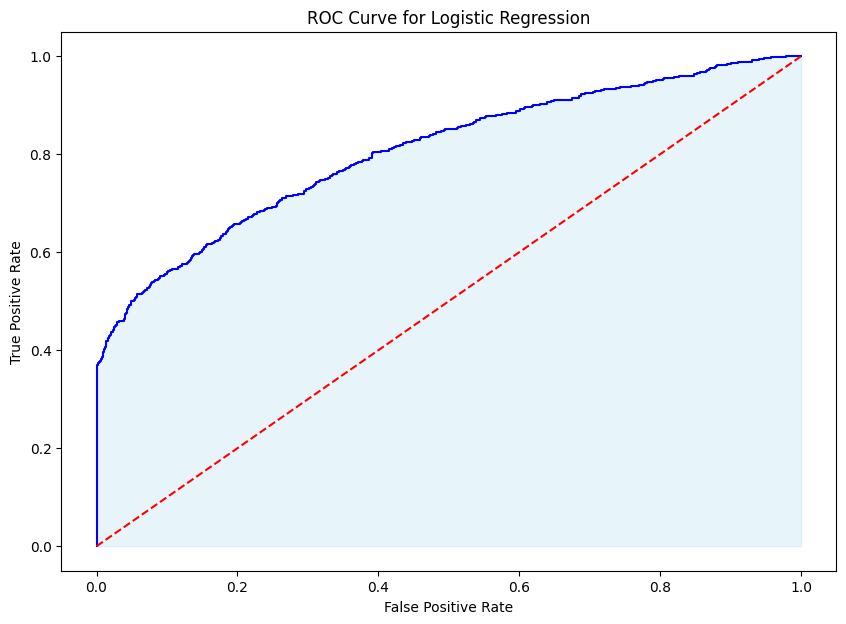

In [121]:
param_grid = {
    'solver': ['sag', 'lbfgs', 'liblinear'],  # Different solvers to try
    'C': [ 0.01],  # Regularization strength
    'penalty': ['l2'],  # Penalty type (l1 can only be used with some solvers)
    'max_iter': [5000, 4000]  # Iterations for convergence
    
}

# Instantiate the logistic regression model
lr = LogisticRegression()

# Set up the GridSearchCV
grid_search = GridSearchCV(estimator=lr,
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='roc_auc',  # AUC score for evaluation
                           verbose=1,
                           n_jobs=-1)

# Fit the model on the training data
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_lr_model = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)

# Predictions using the best model
y_pred = best_lr_model.predict(X_val)
y_pred_proba = best_lr_model.predict_proba(X_val)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Accuracy: {accuracy * 100.0}%")
print(f"AUC Score: {auc_score}")
evaluate(y_val,y_pred,y_pred_proba, "Logistic Regression")

## Model 3: XGBoost

Cross-Validation ROC-AUC Scores: [0.82919104 0.84437413 0.82613435 0.83366995 0.83671862]
Average Cross-Validation ROC-AUC Score: 0.8340176191566172
Test Set Accuracy: 88.925%
Test Set AUC Score: 0.8085247656149663

Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      3290
           1       0.98      0.39      0.55       710

    accuracy                           0.89      4000
   macro avg       0.93      0.69      0.74      4000
weighted avg       0.90      0.89      0.87      4000



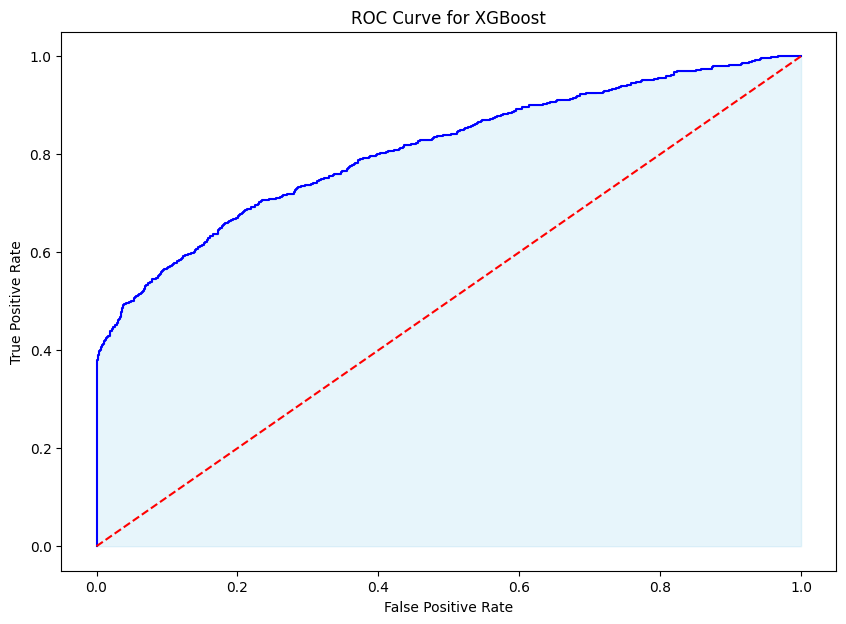

In [122]:
params = {'subsample': 0.7222222222222222, 'reg_lambda': 0.6666666666666666, 'reg_alpha': 0.5555555555555556, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.019999999999999997, 'gamma': 0.05555555555555555, 'colsample_bytree': 0.5
          }

# Initialize XGBoost Classifier with selected parameters
xgb_model = xgb.XGBClassifier(**params)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')

# Train the model on the entire training set
xgb_model.fit(X_train, y_train)

# Predictions on the test set
xgb_y_pred = xgb_model.predict(X_val)
y_pred_proba = xgb_model.predict_proba(X_val)[:, 1]

# Calculate accuracy and AUC Score on the test set
xgb_accuracy = accuracy_score(y_val, xgb_y_pred)
xgb_auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")
print(f"Test Set Accuracy: {xgb_accuracy * 100.0}%")
print(f"Test Set AUC Score: {xgb_auc_score}")

# # Display feature importance
# feature_importance = xgb_model.feature_importances_
# sorted_idx = np.argsort(feature_importance)[::-1]

# print("\nTop 10 Feature Importance:")
# for i in range(10):
#     print(f"{train_balanced[sorted_idx[i]]}: {feature_importance[sorted_idx[i]]}")
evaluate(y_val,xgb_y_pred,y_pred_proba, "XGBoost")

# Model - LightGBM

[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.6785986360743963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6785986360743963
[LightGBM] [Warning] lambda_l1 is set=0.003084514923441306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003084514923441306
[LightGBM] [Warning] bagging_fraction is set=0.7559247410755839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7559247410755839
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=22, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=22
[LightGBM] [Warning] feature_fraction is set=0.6785986360743963, colsample_bytre

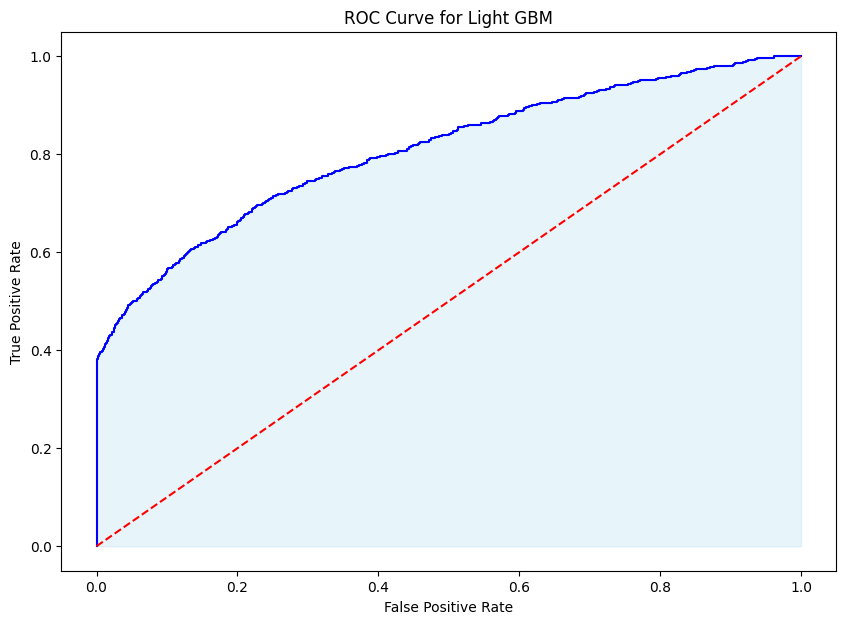

In [123]:
params = {'bagging_fraction': 0.7559247410755839, 'bagging_freq': 2, 'feature_fraction': 0.6785986360743963, 'lambda_l1': 0.003084514923441306, 'learning_rate': 0.041501214401114275, 'max_depth': 15, 'min_data_in_leaf': 22, 'n_estimators': 136, 'num_leaves': 31
          }

# Initialize LightGBM Classifier with selected parameters
lgb_model = lgb.LGBMClassifier(**params)

# Perform cross-validation
cv_scores = cross_val_score(lgb_model,X_train, y_train, cv=5, scoring='roc_auc')

# Train the model on the entire training set
lgb_model.fit(X_train, y_train)

# Predictions on the test set
lgb_y_pred = lgb_model.predict(X_val)
y_pred_proba = lgb_model.predict_proba(X_val)[:, 1]

# Calculate accuracy and AUC Score on the test set
lgb_accuracy = accuracy_score(y_val, lgb_y_pred)
lgb_auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")
print(f"Test Set Accuracy: {lgb_accuracy * 100.0}%")
print(f"Test Set AUC Score: {lgb_auc_score}")
evaluate(y_val,lgb_y_pred,y_pred_proba, "Light GBM")

In [124]:
# lgb.plot_importance(lgb_model, importance_type="gain", max_num_features=15 ,figsize=(20,15), title="LightGBM Feature Importance (Gain)", grid=False, color = "#009dd9")
# plt.show()


## Model 4: Gradient Boosting

Cross-Validation ROC-AUC Scores: [0.83160871 0.83852721 0.82615973 0.83235385 0.83594139]
Average Cross-Validation ROC-AUC Score: 0.8329181743103641
Test Set Accuracy: 88.97500000000001%
Test Set AUC Score: 0.8100329637398862

Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      3290
           1       0.98      0.39      0.55       710

    accuracy                           0.89      4000
   macro avg       0.93      0.69      0.75      4000
weighted avg       0.90      0.89      0.87      4000



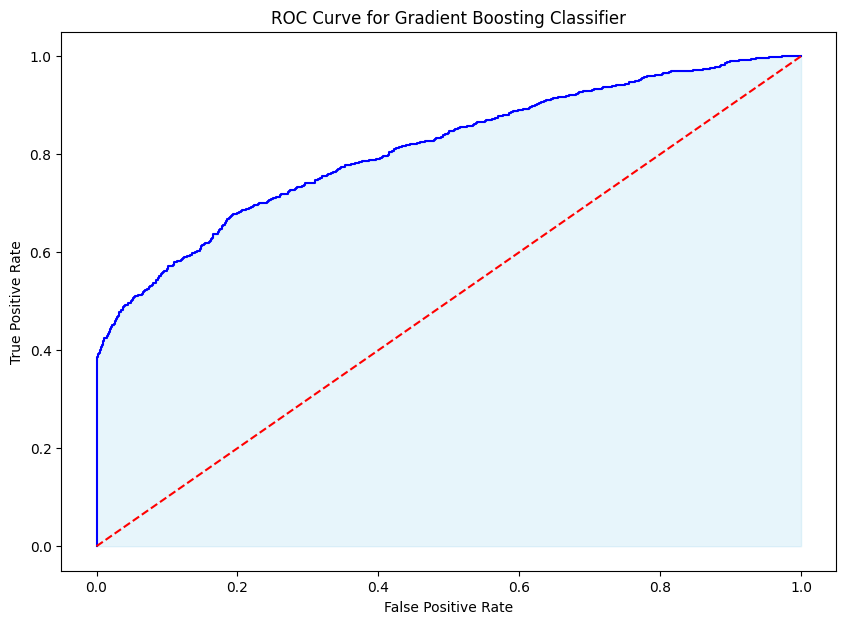

In [125]:
# Manually select parameters from the parameter grid
params = {
    'n_estimators': 245,
    'learning_rate': 0.01,
    'max_depth': 7,
    'min_samples_split': 5,
    'min_samples_leaf': 3,
    'max_features': 'sqrt',
    'subsample': 0.8
    
}


# Initialize Gradient Boosting Classifier with selected parameters
gb_model = GradientBoostingClassifier(**params)

# Perform cross-validation
cv_scores = cross_val_score(gb_model, X_train, y_train, cv=5, scoring='roc_auc')

# Train the model on the entire training set
gb_model.fit(X_train, y_train)

# Predictions on the test set
gb_y_pred = gb_model.predict(X_val)
y_pred_proba = gb_model.predict_proba(X_val)[:, 1]

# Calculate accuracy and AUC Score on the test set
gb_accuracy = accuracy_score(y_val, gb_y_pred)
gb_auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {cv_scores.mean()}")
print(f"Test Set Accuracy: {gb_accuracy * 100.0}%")
print(f"Test Set AUC Score: {gb_auc_score}")
evaluate(y_val,gb_y_pred,y_pred_proba, "Gradient Boosting Classifier")


## Model 5: CatBoost

0:	learn: 0.6838615	total: 11.8ms	remaining: 2.58s
1:	learn: 0.6743096	total: 24.2ms	remaining: 2.64s
2:	learn: 0.6651093	total: 34.8ms	remaining: 2.52s
3:	learn: 0.6568391	total: 47.7ms	remaining: 2.58s
4:	learn: 0.6486256	total: 59.3ms	remaining: 2.55s
5:	learn: 0.6400407	total: 71.9ms	remaining: 2.56s
6:	learn: 0.6322931	total: 83.2ms	remaining: 2.53s
7:	learn: 0.6246827	total: 94.2ms	remaining: 2.5s
8:	learn: 0.6171841	total: 106ms	remaining: 2.48s
9:	learn: 0.6098540	total: 118ms	remaining: 2.47s
10:	learn: 0.6028666	total: 128ms	remaining: 2.42s
11:	learn: 0.5957102	total: 138ms	remaining: 2.4s
12:	learn: 0.5888486	total: 150ms	remaining: 2.39s
13:	learn: 0.5823920	total: 162ms	remaining: 2.38s
14:	learn: 0.5762836	total: 167ms	remaining: 2.29s
15:	learn: 0.5695417	total: 179ms	remaining: 2.29s
16:	learn: 0.5632147	total: 191ms	remaining: 2.29s
17:	learn: 0.5571323	total: 203ms	remaining: 2.28s
18:	learn: 0.5511425	total: 217ms	remaining: 2.29s
19:	learn: 0.5454117	total: 228ms	r

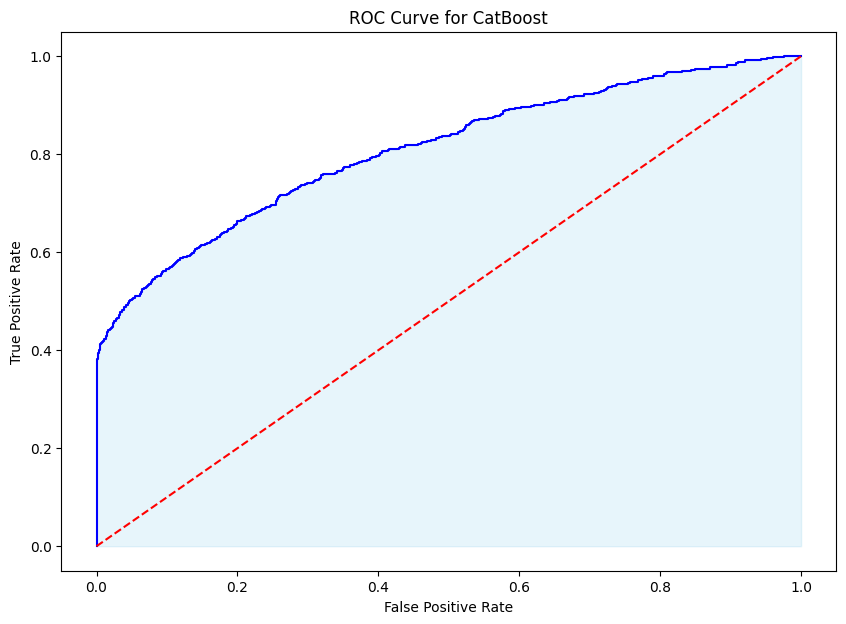

In [126]:
from catboost import CatBoostClassifier

# Manually select parameters from the parameter grid
params = {
    'depth': 8,
    'learning_rate': 0.01,
    'iterations': 220,
    'l2_leaf_reg': 3,
    'border_count': 50,
    'bagging_temperature': 0.04019881483063329,
    'loss_function': 'Logloss',
    'od_type': 'Iter',
    'od_wait': 50,
    'verbose': True
}

# Initialize CatBoost Classifier with selected parameters
cat_model = CatBoostClassifier(**params)

# Perform cross-validation
cv_scores = cross_val_score(cat_model, X_train, y_train, cv=5, scoring='roc_auc')

# Train the model on the entire training set
cat_model.fit(X_train, y_train)

# Predictions on the test set
cat_y_pred = cat_model.predict(X_val)
y_pred_proba = cat_model.predict_proba(X_val)[:, 1]

# Calculate accuracy and AUC Score on the test set
cat_accuracy = accuracy_score(y_val, cat_y_pred)
cat_auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")
print(f"Test Set Accuracy: {cat_accuracy * 100.0}%")
print(f"Test Set AUC Score: {cat_auc_score}")
evaluate(y_val,cat_y_pred,y_pred_proba, "CatBoost")


## Model 6: Random Forest

Cross-Validation ROC-AUC Scores: [0.83373109 0.83740258 0.82258282 0.82634313 0.82737799]
Average Cross-Validation ROC-AUC Score: 0.8294875205401177
Test Set Accuracy: 88.94999999999999%
Test Set AUC Score: 0.8053225737403141

Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      3290
           1       0.99      0.38      0.55       710

    accuracy                           0.89      4000
   macro avg       0.94      0.69      0.74      4000
weighted avg       0.90      0.89      0.87      4000



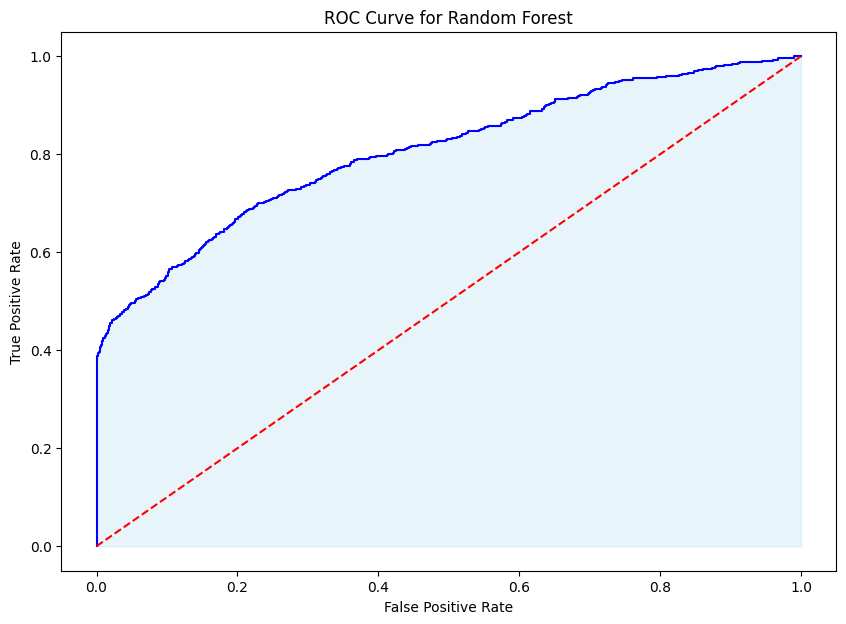

In [127]:
# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=300,
    n_jobs=-1,
    max_depth=16,
    min_samples_split=10,
    min_samples_leaf=7,
    max_features='sqrt',
    bootstrap=True,
    criterion='gini',
    random_state=42,
    
)

# Perform cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')

# Train the model on the entire training set
rf_model.fit(X_train, y_train)

# Predictions on the test set
rf_y_pred = rf_model.predict(X_val)
y_pred_proba = rf_model.predict_proba(X_val)[:, 1]

# Calculate accuracy and AUC Score on the test set
rf_accuracy = accuracy_score(y_val, rf_y_pred)
rf_auc_score = roc_auc_score(y_val, y_pred_proba)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")
print(f"Test Set Accuracy: {rf_accuracy * 100.0}%")
print(f"Test Set AUC Score: {rf_auc_score}")
evaluate(y_val,rf_y_pred,y_pred_proba, "Random Forest")


# Final Results

In [128]:
final_results = pd.DataFrame(results)
final_results

,Model,ROC AUC Score,F1-Score
0,Baseline Logistic Regression,0.650259,0.742394
1,Light GBM Baseline,0.799504,0.869726
2,Logistic Regression,0.805494,0.864152
3,XGBoost,0.808525,0.868668
4,Light GBM,0.807054,0.868046
5,Gradient Boosting Classifier,0.810033,0.869116
6,CatBoost,0.808322,0.868157
7,Random Forest,0.805323,0.868453


# Fit Best Model on Test Set: Gradient Boosting

Cross-Validation ROC-AUC Scores: [0.83373109 0.83740258 0.82258282 0.82634313 0.82737799]
Average Cross-Validation ROC-AUC Score: 0.8294875205401177
Test Set Accuracy: 89.2%
Test Set AUC Score: 0.8246712463865534

Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94      3282
           1       0.99      0.40      0.57       718

    accuracy                           0.89      4000
   macro avg       0.94      0.70      0.75      4000
weighted avg       0.90      0.89      0.87      4000



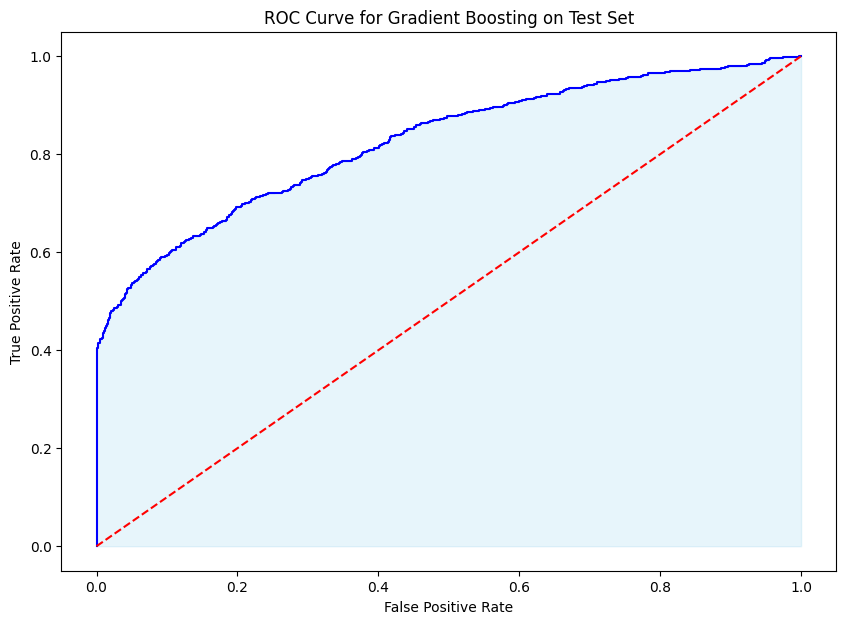

In [129]:

# Predictions on the test set
gb_y_pred = gb_model.predict(X_test)
y_pred_proba = gb_model.predict_proba(X_test)[:, 1]

# Calculate accuracy and AUC Score on the test set
gb_accuracy = accuracy_score(y_test, gb_y_pred)
gb_auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Cross-Validation ROC-AUC Scores: {cv_scores}")
print(f"Average Cross-Validation ROC-AUC Score: {np.mean(cv_scores)}")
print(f"Test Set Accuracy: {gb_accuracy * 100.0}%")
print(f"Test Set AUC Score: {gb_auc_score}")
evaluate(y_test,gb_y_pred,y_pred_proba, "Gradient Boosting on Test Set")